In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,PReLU,Softmax,Flatten,Input
from tensorflow.keras.models import Model
import cv2


In [2]:
def build_p_network(input_shape = None):
    if input_shape is None:
        input_shape = (None,None,3)
    p_inp = Input(input_shape)
    p_net = Conv2D(10,(3,3),(1,1),'valid')(p_inp)
    p_net = PReLU(shared_axes=[1,2])(p_net)
    p_net = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(p_net)
    p_net = Conv2D(16,(3,3),(1,1),'valid')(p_net)
    p_net = PReLU(shared_axes= [1,2])(p_net)
    p_net = Conv2D(32,(3,3),(1,1),'valid')(p_net)
    p_net = PReLU(shared_axes= [1,2])(p_net)
    p_out_1 = Conv2D(2,(1,1),(1,1),'valid')(p_net)
    p_out_1 = Softmax(axis=3)(p_out_1)
    p_out_2 = Conv2D(4,(1,1),(1,1),'valid')(p_net)

    model = Model(p_inp,[p_out_2,p_out_1])
    
    return model

def build_r_network(input_shape = None):
    if input_shape is None:
        input_shape = (24,24,3)
    r_inp = Input(input_shape)
    r_net = Conv2D(28,(3,3),(1,1),'valid')(r_inp)
    r_net = PReLU(shared_axes=[1,2])(r_net)
    r_net = MaxPooling2D((3,3),(2,2),'same')(r_net)

    r_net = Conv2D(48,(3,3),(1,1),'valid')(r_net)
    r_net = PReLU(shared_axes=[1,2])(r_net)
    r_net = MaxPooling2D((3,3),(2,2),'valid')(r_net)
    
    r_net = Conv2D(64,(2,2),(1,1),'valid')(r_net)
    r_net = PReLU(shared_axes=[1,2])(r_net)
    r_net = Flatten()(r_net)
    r_net = Dense(128)(r_net)
    r_net = PReLU()(r_net)
    r_out_1 = Dense(2)(r_net)
    r_out_1 = Softmax(axis=1)(r_out_1)
    r_out_2 = Dense(4)(r_net)
    model = Model(r_inp,[r_out_2,r_out_1])
    return model

def build_o_network(input_shape = None):
    if input_shape is None:
        input_shape = (48,48,3)
    
    o_inp = Input(input_shape)
    o_net = Conv2D(32,(3,3),(1,1),'valid')(o_inp)
    o_net = PReLU(shared_axes=[1,2])(o_net)
    o_net = MaxPooling2D((3,3),(2,2),'same')(o_net)
    o_net = Conv2D(64,(3,3),(1,1),'valid')(o_net)
    o_net = PReLU(shared_axes=[1,2])(o_net)
    o_net = MaxPooling2D((3,3),(2,2),'valid')(o_net)
    o_net = Conv2D(64,(3,3),(1,1),'valid')(o_net)
    o_net = PReLU(shared_axes=[1,2])(o_net)
    o_net = MaxPooling2D((2,2),(2,2),'same')(o_net)
    o_net = Conv2D(128,(2,2),(1,1),'valid')(o_net)
    o_net = PReLU(shared_axes=[1,2])(o_net)
    o_net = Flatten()(o_net)
    o_net = Dense(256)(o_net)
    o_net = PReLU()(o_net) 
    o_out_1 = Dense(2)(o_net)
    o_out_1 = Softmax(axis=1)(o_out_1)
    o_out_2 = Dense(4)(o_net)
    o_out_3 = Dense(10)(o_net)
    model = Model(o_inp,[o_out_2,o_out_3,o_out_1])

    return model

def build_pro_network(file):
    p_net = build_p_network()
    r_net = build_r_network()
    o_net = build_o_network()
    weights = np.load(file, allow_pickle=True).tolist()
    p_net.set_weights(weights['pnet']) 
    r_net.set_weights(weights['rnet'])
    o_net.set_weights(weights['onet'])
    return p_net,r_net,o_net



In [3]:
class StageStatus(object):
    def __init__(self, pad_result: tuple = None, width=0, height=0):
        self.width = width
        self.height = height
        self.x = self.y = self.endx = self.endy = self.offset_x = self.offset_y = self.offset_endx = self.offset_endy = self.tmpw = self.tmph = []
        if pad_result is not None:
            self.update(pad_result)

    def update(self,pad_result):
        self.x, self.y, self.endx, self.endy, self.offset_x, self.offset_y, self.offset_endx, self.offset_endy, self.tmpw, self.tmph = pad_result


In [8]:
class myMTCNN(object):
    def __init__(self,min_face_size:int = 20,scale_factor:float = 0.709,threshold : list = None):
        self.min_face_size = min_face_size
        self.scale_factor = scale_factor
        if threshold is None:
            threshold = [0.6,0.7,0.7]
        self.threshold = threshold
        self.p_net,self.r_net,self.o_net = build_pro_network('mtcnn_weights.npy')


    def create_scale_pyramid(self,m,min_layer):
        scales = []
        count = 0
        while min_layer >= 12 :
            scales += [m * np.power(self.scale_factor,count)]
            min_layer *= self.scale_factor
            count += 1
        return scales

    @staticmethod
    def scale_image(img,scale):
        width = int (np.ceil(scale * img.shape[1]))
        height = int (np.ceil(scale * img.shape[0]))
        img = cv2.resize(img,(width,height),interpolation=cv2.INTER_AREA)
        img = (img - 127.5) * 0.0078125
        return img


    @staticmethod
    def generate_bounding_box(imap,scale,reg,threshold):
        dx1 = reg[:,:,0]
        dy1 = reg[:,:,1]
        dx2 = reg[:,:,2]
        dy2 = reg[:,:,3]

        y, x = np.where(imap >= threshold)

        if y.shape[0] == 1:
     #       print("flipud")
            dx1 = np.flipud(dx1)
            dy1 = np.flipud(dy1)
            dx2 = np.flipud(dx2)
            dy2 = np.flipud(dy2)

        score = imap[(y,x)]
        reg = np.vstack([dx1[(y,x)], dy1[(y,x)], dx2[(y,x)], dy2[(y,x)]])
        reg = np.transpose(reg)

##############################################
        if reg.size == 0:
            reg = np.empty(shape=(0, 3))

        strides = 2
        cellsize = 12
        bb = np.transpose(np.vstack([x,y]))
        qs = np.fix((bb * strides + 1) / scale)
        qe = np.fix((bb * strides + cellsize)/scale)
        
        bounding_boxes = np.hstack([qs,qe,np.expand_dims(score,1),reg])
        return bounding_boxes,reg

    @staticmethod
    def non_max_supression(boxes,threshold,method):
        if boxes.size == 0:
            return np.empty((0, 3))
        upper_left_x = boxes[:,0]
        upper_left_y = boxes[:,1]
        down_right_x = boxes[:,2]
        down_right_y = boxes[:,3]
        scores = boxes[:,4]
        area_of_all_boxes = (down_right_x - upper_left_x + 1) * (down_right_y - upper_left_y + 1)
        sorted_index = np.argsort(scores)

        count = 0
        pick = np.zeros_like(scores,dtype = np.int16)

        while sorted_index.size > 0:

            max_score_box_index = sorted_index[-1]
            pick[count] = max_score_box_index
            count += 1
            other_boxes_index = sorted_index[0:-1]

            intersection_upper_left_x = np.maximum(upper_left_x[other_boxes_index],upper_left_x[max_score_box_index])
            intersection_upper_left_y = np.maximum(upper_left_y[other_boxes_index],upper_left_y[max_score_box_index])
            intersection_down_right_x = np.minimum(down_right_x[other_boxes_index],down_right_x[max_score_box_index])
            intersection_down_right_y = np.minimum(down_right_y[other_boxes_index],down_right_y[max_score_box_index])

            intersection_box_h = np.maximum(0.0,intersection_down_right_y-intersection_upper_left_y+1)
            intersection_box_w = np.maximum(0.0,intersection_down_right_x-intersection_upper_left_x+1)

            area = intersection_box_h * intersection_box_w

            if method is 'Union':
                o = area / (area_of_all_boxes[other_boxes_index] + area_of_all_boxes[max_score_box_index] - area)
            else:
                o = area / np.minimum(area_of_all_boxes[other_boxes_index],area_of_all_boxes[max_score_box_index])

            remaining_ones_index = np.where(o <= threshold)
            sorted_index = sorted_index[remaining_ones_index]

        pick = pick[0:count]
        return pick

    @staticmethod
    def to_square(box):
        width = box[:,2] - box[:,0]
        height = box[:,3] - box[:,1]
        mx = np.maximum(width,height)
        box[:,0] = box[:,0] + 0.5 * (width - mx)
        box[:,1] = box[:,1] + 0.5 * (height - mx)
        box[:,2:4] = box[:,0:2] + np.transpose(np.tile(mx,(2,1)))
        return box

    @staticmethod
    def padding(boxes,w,h):
        number_of_boxes = boxes.shape[0]
        tmpw = (boxes[:,2] - boxes[:,0] + 1).astype(np.int32)
        tmph = (boxes[:,3] - boxes[:,1] + 1).astype(np.int32)
        x = boxes[:,0].copy().astype(np.int32)
        y = boxes[:,1].copy().astype(np.int32)
        endx = boxes[:,2].copy().astype(np.int32)
        endy = boxes[:,3].copy().astype(np.int32)
        offset_x = np.ones(number_of_boxes,dtype = np.int32)
        offset_y = np.ones(number_of_boxes,dtype = np.int32)
        offset_endx = tmpw.copy().astype(np.int32)
        offset_endy = tmph.copy().astype(np.int32)

        tmp = np.where(endx > w)
        offset_endx[tmp] = tmpw[tmp] - (endx[tmp] - w)
        endx[tmp] = w

        tmp = np.where(endy > h)
        offset_endy[tmp] = tmph[tmp] - (endy[tmp] - h)
        endy[tmp] = h

        tmp = np.where(x < 1)
        offset_x[tmp] = 2 - x[tmp]
        x[tmp] = 1

        tmp = np.where(y < 1)
        offset_y[tmp] = 2 - y[tmp]
        y[tmp] = 1

        return x,y,endx,endy,offset_x,offset_y,offset_endx,offset_endy,tmpw,tmph


    def stage1(self,img,scales,status):
        width = img.shape[1]
        height = img.shape[0]
     #   print("scale ssize : " , len(scales) )
        total_boxes = np.empty((0,9))
        for scale in scales:
            scaled_image = self.scale_image(img,scale)
            scaled_image = np.expand_dims(scaled_image,0)
            scaled_image = np.transpose(scaled_image,(0,2,1,3))
      #      print("scaled image shape ", scaled_image.shape)
            p_predict = self.p_net.predict(scaled_image)
            probs = p_predict[1]
            boxes = p_predict[0]
            probs = np.transpose(probs,(0,2,1,3))
            boxes = np.transpose(boxes,(0,2,1,3))
            bounding_boxes, regression = self.generate_bounding_box(probs[0,:,:,1].copy(),scale,boxes[0,:,:,:].copy(),self.threshold[0])
            pick = self.non_max_supression(bounding_boxes.copy(),0.5,'Union')
            if bounding_boxes.size > 0 and pick.size > 0 :
                bounding_boxes = bounding_boxes[pick,:]
                total_boxes = np.append(total_boxes,bounding_boxes,axis = 0)
        
        number_of_boxes = total_boxes.shape[0]
     #   print("number of boxes : " , number_of_boxes)
        if number_of_boxes > 0:
            pick = self.non_max_supression(total_boxes.copy(),0.7,'Union')
            boxes = total_boxes[pick,:]

            boxes_h = boxes[:,3] - boxes[:,1] 
            boxes_w = boxes[:,2] - boxes[:,0]
            actual_left_x = boxes[:,0] + boxes_w * boxes[:,5]
            actual_left_y = boxes[:,1] + boxes_h * boxes[:,6]
            actual_right_x = boxes[:,2] + boxes_w * boxes[:,7]
            actual_right_y = boxes[:,3] + boxes_h * boxes[:,8]
            boxes = np.transpose(np.vstack([actual_left_x,actual_left_y,actual_right_x,actual_right_y,boxes[:,4]]))
       #     print("total boxes : " , boxes.shape)
            boxes = self.to_square(boxes.copy())
            boxes[:,0:4] = np.fix(boxes[:, 0:4]).astype(np.int32)
            status = StageStatus(self.padding(boxes.copy(),width,height),width,height)
            return boxes,status
        
    
    def stage2(self,img,boxes,status:StageStatus):
        num_boxes = boxes.shape[0]
        tmp_image = np.zeros((num_boxes,24,24,3))
        for i in range(0,num_boxes):
        #    print(status.endy[i]-status.y[i]-1)
            padded_image = np.zeros((int(status.tmph[i]),int(status.tmpw[i]),3))
            padded_image[status.offset_y[i]-1:status.offset_endy[i],status.offset_x[i]-1:status.offset_endx[i],:] = \
            img[status.y[i]-1:status.endy[i],status.x[i]-1:status.endx[i],:]
            if padded_image.shape[0] > 0 and padded_image.shape[1] > 0 or padded_image.shape[0] == 0 and padded_image.shape[1] == 0:
                tmp_image[i,:,:,:] = cv2.resize(padded_image,(24,24),interpolation = cv2.INTER_AREA)
            else:
                print("return from stage2")
        
        tmp_image = (tmp_image - 127.5) * 0.0078125
        tmp_image = np.transpose(tmp_image,(0,2,1,3))
        rOut = self.r_net.predict(tmp_image)
        probs = rOut[1]
        reg = rOut[0]
    #    print("reg shape : ",reg.shape)
        scores = probs[:,1]
        
        index = np.where(scores > self.threshold[1])

        boxes = np.hstack([boxes[index[0],0:4].copy(),np.expand_dims(scores[index[0]].copy(),1)])   ################
        reg = reg[index[0],:]

        if boxes.shape[0] > 0:
            pick = self.non_max_supression(boxes,0.7,'Union')
            boxes = boxes[pick,:]
            boxes = self.calibrate(boxes.copy(),reg[pick,0:4])
            boxes = self.to_square(boxes.copy())
            boxes = np.fix(boxes).astype(np.int32)
            status = StageStatus(self.padding(boxes,status.width,status.height),status.width,status.height)

        return boxes,status


    def stage3(self,img,boxes,status:StageStatus):
        num_boxes = boxes.shape[0]
        if num_boxes == 0 : 
            return boxes,np.empty(shape=(0,))
        tmp_image = np.zeros((num_boxes,48,48,3))
        
        for i in range(0,num_boxes):
            padded_image = np.zeros((int(status.tmph[i]),int(status.tmpw[i]),3))
            padded_image[status.offset_y[i]-1:status.offset_endy[i],status.offset_x[i]-1:status.offset_endx[i],:] = \
            img[status.y[i]-1:status.endy[i],status.x[i]-1:status.endx[i],:]
            if padded_image.shape[0] > 0 and padded_image.shape[1] > 0 or padded_image.shape[0] == 0 and padded_image.shape[1] == 0:
                tmp_image[i,:,:,:] = cv2.resize(padded_image,(48,48),interpolation = cv2.INTER_AREA)
            else:
                print("return from stage2")

        tmp_image = (tmp_image - 127.5) * 0.0078125
        tmp_image = np.transpose(tmp_image,(0,2,1,3))
        Oout = self.o_net.predict(tmp_image)
        reg = Oout[0]
        points = Oout[1]
        probs = Oout[2]
        score = probs[:,1]
        index = np.where(score > self.threshold[2])
        boxes = np.hstack([boxes[index[0],0:4].copy(),np.expand_dims(score[index[0]].copy(),1)])
        if boxes.shape[0] > 0:
            boxes = self.calibrate(boxes.copy(),reg[index[0],:])
            pick = self.non_max_supression(boxes,.7,'Min')
            boxes = boxes[pick,:]
            points = points[pick,:]
        
        return boxes,points
        
    @staticmethod
    def calibrate(boxes,reg):
        ##############################################
        w = boxes[:,2] - boxes[:,0] + 1
        h = boxes[:,3] - boxes[:,1] + 1
        #############################################
        boxes[:,0] = boxes[:,0] + reg[:,0] * w
        boxes[:,1] = boxes[:,1] + reg[:,1] * h
        boxes[:,2] = boxes[:,2] + reg[:,2] * w
        boxes[:,3] = boxes[:,3] + reg[:,3] * h 

        return boxes



    def detect_faces(self,img):
        height, width, _ = img.shape
        m = 12 / self.min_face_size
        min_layer = m * min(width,height)
        scales = self.create_scale_pyramid(m,min_layer)
        status = StageStatus(width = width,height = height)
        boxes, status =  self.stage1(img,scales,status)
        boxes,status = self.stage2(img,boxes,status)
        boxes,points = self.stage3(img,boxes,status)

        bounding_boxes = []

        for bounding_box,keypoints in zip(boxes,points):
            x = max(0, int(bounding_box[0]))
            y = max(0, int(bounding_box[1]))
            width = int(bounding_box[2] - x)
            height = int(bounding_box[3] - y)
            bounding_boxes.append({
                'box': [x, y, width, height],
                'confidence': bounding_box[-1],
                'keypoints': {
                    'left_eye': (int(keypoints[0]), int(keypoints[5])),
                    'right_eye': (int(keypoints[1]), int(keypoints[6])),
                    'nose': (int(keypoints[2]), int(keypoints[7])),
                    'mouth_left': (int(keypoints[3]), int(keypoints[8])),
                    'mouth_right': (int(keypoints[4]), int(keypoints[9])),
                }
            })
        return bounding_boxes


image shape  (491, 885, 3)


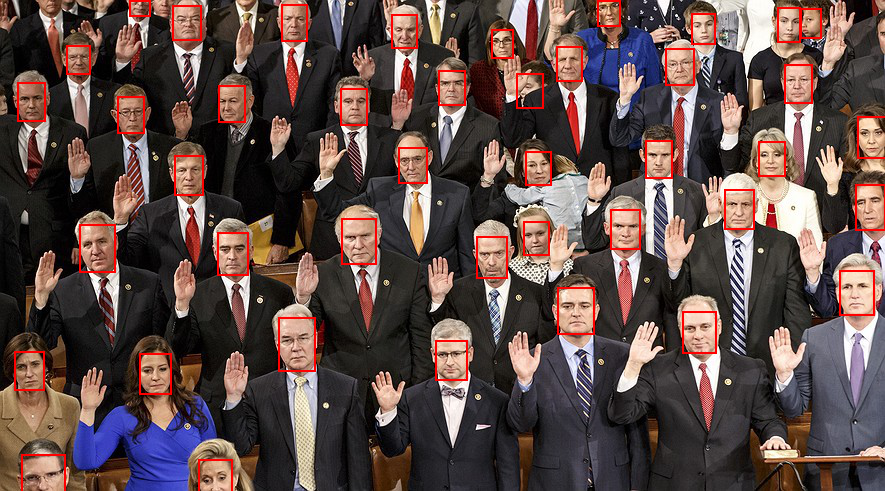

In [21]:
# face detection with mtcnn on a photograph
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
from seaborn import color_palette

# draw an image with detected objects
def draw_image_with_boxes(filename, result_list,save_dir = None):
    data = Image.open(filename)
    draw = ImageDraw.Draw(data)
  #  print(data.shape)
  #  pyplot.imshow(data)
  #  ax = pyplot.gca()
    for result in result_list:
        x, y, width, height = result['box']
        thickness = 2
        xy = [x,y,x+width,y+height]
        for t in np.linspace(0, 1, thickness):
            xy[0], xy[1] = xy[0] + t, xy[1] + t
            xy[2], xy[3] = xy[2] - t, xy[3] - t
            draw.rectangle(xy, outline=(255,0,0))
     #   rect = Rectangle((x, y), width, height, fill=False, color='red')
    #    ax.add_patch(rect)
     #   draw.rectangle([x,y,x+width,y+height],outline=(255,0,0))
  #  pyplot.imsave("test3.jpg",data)
 #   pyplot.show()
    display(data)
    if save_dir != None:
        data.save(save_dir)

filename = 'test-images/test03.jpeg'
# load image from file
pixels = pyplot.imread(filename)
# create the detector, using default weights
detector = myMTCNN()
print("image shape ", pixels.shape )
# detect faces in the image
faces = detector.detect_faces(pixels)
# display faces on the original image
draw_image_with_boxes(filename, faces,'test-images/results/test03.jpeg')

In [ ]:

filename = '/content/test.jpg'
img = plt.imread(filename)
print(img.shape)
model = myMTCNN()
model.detect_face(img)


In [ ]:
print(tf.__version__)

2.2.0
